In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
# import FCMA as f
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
# f = importlib.reload(f)

%matplotlib notebook

In [2]:
# plt.rcParams.update({'font.size': 15})

In [431]:
class integratedLH:
    def __init__(self, f):
        from iminuit.util import make_func_code
        from iminuit import describe
        self.f = f
        
        self.func_code = make_func_code(describe(self.f))
    
    def __call__(self, *par):
        return self.f(*par)
    
    def default_errordef(self):
        return 0.5

def gauss(x,mu,sigma):
        x = np.asarray(x).reshape(-1,1)
        mu = np.expand_dims(mu,0)
        sigma = np.expand_dims(sigma,0)
        return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))
    
def wrapper(mus, sigmas, lim):
    def P_1d(x,mu,sigma,f):
        norm = 2*lim - np.sqrt(np.pi/2)*f*sigma*(erf((mu+lim)/(np.sqrt(2)*sigma))-erf((mu-lim)/(sigma*np.sqrt(2))))
        return (1 - gauss(x,mu,sigma)*f*(sigma*np.sqrt(2*np.pi)))/norm

    w = np.abs(mus) <= lim
    try:
        mus = mus[w]
    except:
        pass
    
    def LF2_1d(mu, sigma, f):
#         def integrand(x):
#             return 
#         print(quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0])
#         vals = quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0]
        vals = P_1d(mus,mu,sigma,f)
#         print(w*np.log(vals),w)
        return -np.sum(w*np.log(vals))
    return LF2_1d, P_1d

<IPython.core.display.Javascript object>


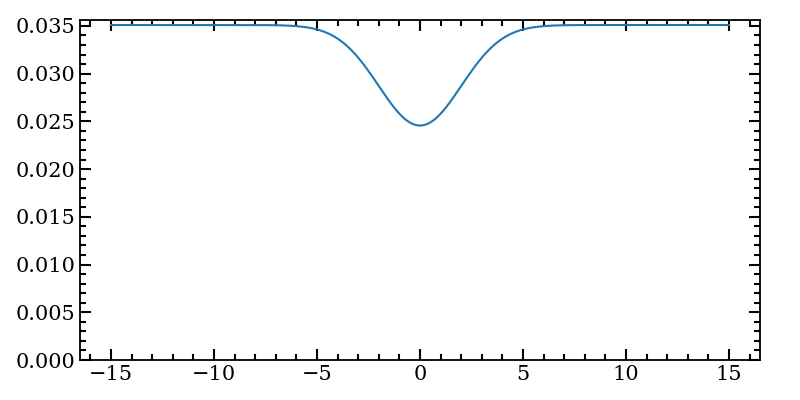

(0, 0.03561899062304914)

In [453]:
gen_lim = 15

tmp, P_1d = wrapper(0,0,gen_lim)

x = np.linspace(-gen_lim,gen_lim,1000)
mu, sigma, frac = 0, 2, 0.3
signal = P_1d(x,mu,sigma,frac)

fig, ax = plt.subplots()
ax.plot(x,signal)
ax.set_ylim(0,ax.get_ylim()[1])

<IPython.core.display.Javascript object>


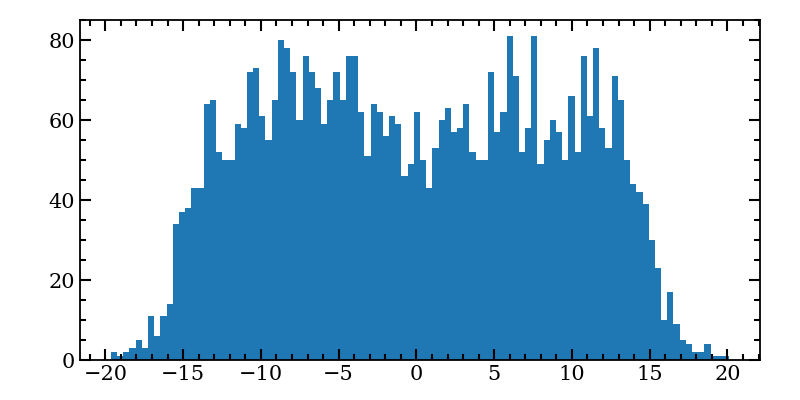

In [454]:
def MCsample(func,xlims,ylims,N_ish):
    Ux = np.random.uniform(*xlims,N_ish)
    Uy = np.random.uniform(*ylims,N_ish)
    return Ux[Uy<=func(Ux).flatten()]

N = 5000

mus = MCsample(lambda Ux: P_1d(Ux,mu,sigma,frac),(-gen_lim,gen_lim),(0,signal.max()),N)
sigmas = np.random.uniform(0.5,3,mus.shape[0])
mus = np.random.normal(mus,sigmas)

fig, ax = plt.subplots()
ax.hist(mus,bins=100);

In [465]:
lim = 10
LF2_1d, P_1d = wrapper(mus,sigmas,lim)
obj = integratedLH(LF2_1d)
M = Minuit(obj,mu=0,sigma=2,f=0.3,limit_sigma=(0,None),limit_mu=(-lim,lim),limit_f=(0,1))

In [468]:
M.migrad()

------------------------------------------------------------------
| FCN = 2.875e+07               |     Ncalls=41 (142 total)      |
| EDM = 0.000868 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |   0.740   |   0.012   |            |            |   -10   |   10    |       |
| 1 | sigma |   2.297   |   0.012   |            |            |    0    |         |       |
| 2 | f     | 194.4e-3  |  0.8e-3   |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


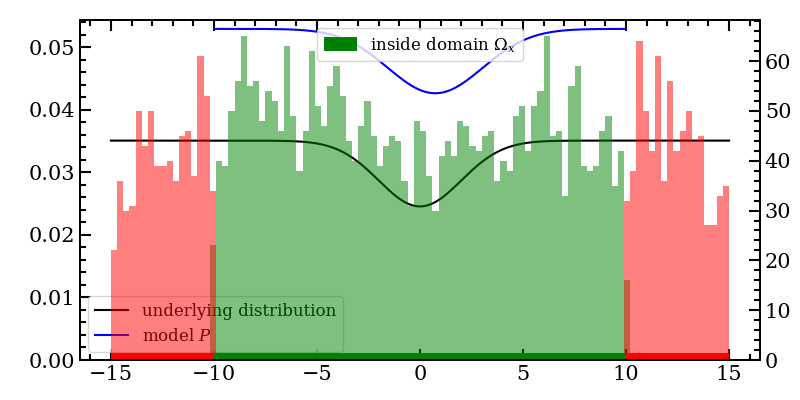

In [469]:
fig, ax = plt.subplots()
# ax.plot(x,f.gauss(x,mus,sigmas).mean(1))

ax.plot(x,signal,label='underlying distribution',c='k')
ax.plot(x[np.abs(x)<=lim],P_1d(x[np.abs(x)<=lim],*M.args),c='b',label='model $P$')
ax.set_ylim(0,ax.get_ylim()[1])
ax_hist = ax.twinx()
ax_hist.hist(mus[np.abs(mus)<=lim],bins=100,range=(-15,15),color='g',alpha=0.5);
ax_hist.hist(mus[np.abs(mus)>lim],bins=100,range=(-15,15),color='r',alpha=0.5);
ax_hist.hlines(0,-lim,lim,'g',linewidth=10,label="inside domain $\Omega_x$")
ax_hist.hlines([0,0],[-15,lim],[-lim,15],'r',linewidth=10)
ax.legend()
ax_hist.legend()

In [458]:
def wrapper2(mus, sigmas, lim):
    def P_1d(x,mu,sigma,f):
        norm = 2*lim - np.sqrt(np.pi/2)*f*sigma*(erf((mu+lim)/(np.sqrt(2)*sigma))-erf((mu-lim)/(sigma*np.sqrt(2))))
        return (1 - gauss(x,mu,sigma)*f*(sigma*np.sqrt(2*np.pi)))/norm

    w = quadpy.quad(lambda x: gauss(x,mus,sigmas).T,-lim,lim)[0]
    
#     mask = w >= 1e-5
    
    def LF2_1d(mu, sigma, f):
#         def integrand(x):
#             return 
#         print(quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0])
        vals = quadpy.quad(lambda x: P_1d(x,mu,sigma,f).T*gauss(x,mus,sigmas).T,-lim,lim)[0]
#         vals = P_1d(mus,mu,sigma,f)
#         print("Here!")
        return -np.sum(w*np.log(vals))
    return LF2_1d, P_1d

In [459]:
LF2_1d, P_1d = wrapper2(mus,sigmas,lim)
obj2 = integratedLH(LF2_1d)
M2 = Minuit(obj2,mu=0,sigma=2,f=0.5,limit_sigma=(0,None),limit_mu=(-lim,lim),limit_f=(0,1))

In [460]:
M2.migrad()

------------------------------------------------------------------
| FCN = 9730                    |     Ncalls=188 (188 total)     |
| EDM = 1.17e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu    |    0.9    |    0.7    |            |            |   -10   |   10    |       |
| 1 | sigma |    2.1    |    0.7    |            |            |    0    |         |       |
| 2 | f     |   0.24    |   0.07    |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [461]:
M2.args

<ArgsView of Minuit at 21185bf0348>
  0.9335360700714972
  2.0598053749928305
  0.23719715591508606

<IPython.core.display.Javascript object>


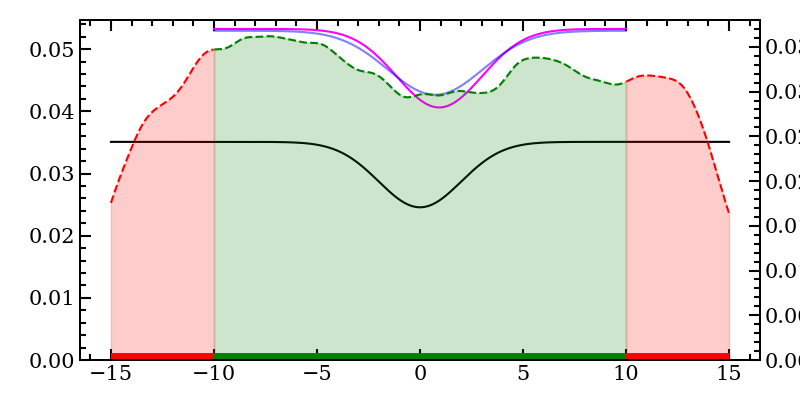

In [470]:
fig, ax = plt.subplots()
# ax.plot(x,f.gauss(x,mus,sigmas).mean(1))

ax.plot(x,signal,label='underlying distribution',c='k')
ax.plot(x[np.abs(x)<=lim],P_1d(x[np.abs(x)<=lim],*M2.args),c='magenta',label='model $P$')
ax.plot(x[np.abs(x)<=lim],P_1d(x[np.abs(x)<=lim],*M.args),c='b',ls='-',label='model $P$',alpha=0.5)
ax.set_ylim(0,ax.get_ylim()[1])
ax_hist = ax.twinx()

# ax_hist.plot(x[np.abs(x)<=lim],gauss(x[np.abs(x)<=lim],mus,sigmas),'g--')
# ax_hist.plot(x[x<-lim],gauss(x[x<-lim],mus,sigmas),'r--')
# ax_hist.plot(x[x>lim],gauss(x[x>lim],mus,sigmas),'r--')

# for i in range(mus.shape[0]):
#     ax_hist.fill_between(x[np.abs(x)<=lim],gauss(x[np.abs(x)<=lim],mus[i],sigmas[i]).max(1),color='g',alpha=0.2)
#     ax_hist.fill_between(x[x<-lim],gauss(x[x<-lim],mus[i],sigmas[i]).max(1),color='r',alpha=0.2)
#     ax_hist.fill_between(x[x>lim],gauss(x[x>lim],mus[i],sigmas[i]).max(1),color='r',alpha=0.2)

ax_hist.plot(x[np.abs(x)<=lim],gauss(x[np.abs(x)<=lim],mus,sigmas).mean(1),'g--')
ax_hist.plot(x[x<-lim],gauss(x[x<-lim],mus,sigmas).mean(1),'r--')
ax_hist.plot(x[x>lim],gauss(x[x>lim],mus,sigmas).mean(1),'r--')


ax_hist.fill_between(x[np.abs(x)<=lim],gauss(x[np.abs(x)<=lim],mus,sigmas).mean(1),color='g',alpha=0.2)
ax_hist.fill_between(x[x<-lim],gauss(x[x<-lim],mus,sigmas).mean(1),color='r',alpha=0.2)
ax_hist.fill_between(x[x>lim],gauss(x[x>lim],mus,sigmas).mean(1),color='r',alpha=0.2)


# ax_hist.hist(mus[np.abs(mus)<=lim],bins=100,range=(-15,15),color='g',alpha=0.5);
# ax_hist.hist(mus[np.abs(mus)>lim],bins=100,range=(-15,15),color='r',alpha=0.5);

ax_hist.set_ylim(0,ax_hist.get_ylim()[1])
ax_hist.hlines(0,-lim,lim,'g',linewidth=10,label="inside domain $\Omega_x$")
ax_hist.hlines([0,0],[-15,lim],[-lim,15],'r',linewidth=10)
# ax.legend()
# ax_hist.legend()

# Moon 2d:

In [474]:
import os
import pickle

In [475]:
filepath = r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\MoonAnalysis\samples"
with open(os.path.join(filepath,'run1_minuit_ArgsErrors.pkl'),'rb') as file:
    M = pickle.load(file)

arr = np.load(os.path.join(filepath,'run1_RecoSigma_N393K.npy'))

<IPython.core.display.Javascript object>


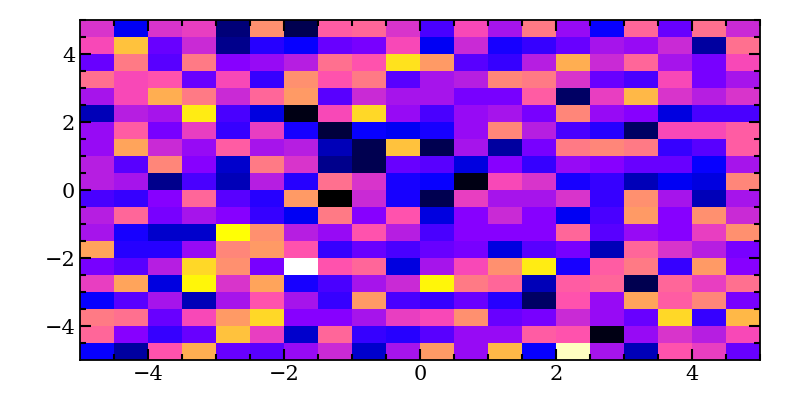

In [485]:
lim = 5

fig, ax = plt.subplots()
ax.hist2d(arr[:,0],arr[:,1],bins=20,range=((-lim,lim),(-lim,lim)));